In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr

import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

In [33]:
from random import gauss
def fake_data2(df, alpha, num):
    def gauss_noise2(inputs, mu, sigma):
       for i in range(len(inputs)):
        inputs[i] += gauss(mu[i], sigma[i])
        return inputs
    sigma = alpha * df.std().values
    mu = [0] * df.shape[1]
    l = len(df)
    for index in range(l):
        for i in range(0, num):
            df.loc[l + index*num+i] = gauss_noise2(df.iloc[index].values, mu, sigma)
    return df.drop(df.head(l).index)

In [3]:
import pandas as pd
import pandas_profiling as pp

file_path = r'D:\Programming\algorithm\AI\mlchem\data.xlsx'
df = pd.read_excel(file_path)
df = df.set_index("Unnamed: 0")
df.index_name = "function_groups"
df_vtrain = df.sample(frac = 0.8)

In [19]:
df.columns = ['Binding Energy', 'Activation Energy', 'Heat of Reaction', 'C-F Bond Length', 'LUMO of Equilibrium Structure', 'HOMO of Equilibrium Structure', 'C-F Bond Energy','b-SOMO', 'C1-Mulliken', 'F-Mulliken', 'C1-NBO', 'F-NBO']

In [20]:
df.index.name = "function groups/parameters"

In [21]:
report = pp.ProfileReport(df)
report.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
features = ['y1', 'y2', 'y3', 'x1', 'x2', 'x3', 'x6', 'x7', 'x10', 'x11', 'x12',
       'x13']

In [83]:
mask = np.zeros_like(df[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [87]:
report = pp.ProfileReport(df)

In [88]:
report.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules.
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title.
    ax1.set_title('Histogram')
    ## plot the histogram.
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title.
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot.
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title.
    ax3.set_title('Box Plot')
    ## Plotting the box plot.
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
plotting_3_chart(df, 'y1')

### LGBM

In [111]:
from dataprocessing import *
from sklearn.utils import shuffle
df_vtrain = df.sample(frac = 0.8)
fake_vtrain = shuffle(fake_data(df_vtrain, 0.1, 10))
X_vtrain = fake_vtrain.loc[:, ['x1', 'x2', 'x3', 'x6', 'x7', 'x10', 'x11', 'x12', 'x13']].values
y_BindingEnergy_vtrain = fake_vtrain.loc[:, ['y1']].values.flatten()
y_ActivationEnergy_vtrain = fake_vtrain.loc[:, ['y2']].values.flatten()
y_Q_vtrain = fake_vtrain.loc[:, ['y3']].values.flatten()

In [112]:
X_vtrain

array([[ 1.34951e+00,  5.44000e-02, -3.22680e-01, ..., -3.06000e-01,
         4.27000e-01, -3.74000e-01],
       [ 1.33987e+00,  5.67500e-02, -3.05010e-01, ..., -2.92000e-01,
         3.87000e-01, -3.61000e-01],
       [ 1.33776e+00, -1.29000e-03, -3.51310e-01, ..., -2.41884e-01,
         4.32730e-01, -3.57580e-01],
       ...,
       [ 1.34065e+00, -1.00200e-02, -3.43580e-01, ..., -2.49274e-01,
         4.27010e-01, -3.63180e-01],
       [ 1.33282e+00,  3.90000e-04, -3.50580e-01, ..., -2.71000e-01,
         4.81000e-01, -3.47000e-01],
       [ 1.34355e+00,  5.01900e-02, -3.19770e-01, ..., -3.06000e-01,
         4.22000e-01, -3.70000e-01]])

In [99]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

file_path = r"D:\Programming\algorithm\AI\mlchem\AE.txt"
txt =np.loadtxt(file_path)
txtdf = pd.DataFrame(txt,index = ['true', 'decisiontree', 'gbrt', 'linreg', 'randomforest'],
                     columns=list('0123456789'))
txtdf = txtdf.T

In [92]:
df['true']= pd.Series([33.337096,35.293045,32.564631,32.389707,30.593679,33.165221,31.650136,31.019074,28.522212,34.184737])
df['decisiontree'] = pd.Series([33.990334,34.225305,32.564631,32.328525,30.242217,33.624678,31.341771,31.688627,31.051705,33.200820])
df['gbrt'] = pd.Series([33.965332,34.195130,32.572494,32.067410,30.862265,32.691491,31.045197,31.982928,29.362183,33.173108])
df['linreg'] = pd.Series([32.690890,33.931633,32.441559,31.379990,31.079267,32.353993,32.465457,32.481132,28.944312,33.388385])
df['randomforest'] = pd.Series([33.573285,33.811862,32.819713,31.866728,30.860288,32.114733,31.431647,32.134892,30.333006,33.140414])

In [100]:
txtdf

,true,decisiontree,gbrt,linreg,randomforest
0,33.337096,33.990334,33.965332,32.690890,33.573285
1,35.293045,34.225305,34.195130,33.931633,33.811862
2,32.564631,32.564631,32.572494,32.441559,32.819713
3,32.389707,32.328525,32.067410,31.379990,31.866728
4,30.593679,30.242217,30.862265,31.079267,30.860288
5,33.165221,33.624678,32.691491,32.353993,32.114733
6,31.650136,31.341771,31.045197,32.465457,31.431647
7,31.019074,31.688627,31.982928,32.481132,32.134892
8,28.522212,31.051705,29.362183,28.944312,30.333006
9,34.184737,33.200820,33.173108,33.388385,33.140414


In [114]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

file_path = r"D:\Programming\algorithm\AI\mlchem\Q.txt"
txt =np.loadtxt(file_path)
txtdf = pd.DataFrame(txt,index = ['true', 'decisiontree', 'gbrt', 'linreg', 'randomforest'],
                     columns=list('0123456789'))
txtdf = txtdf.T
txtdf.plot()
plt.title("Heat of Reaction")
plt.show()

<AxesSubplot:>

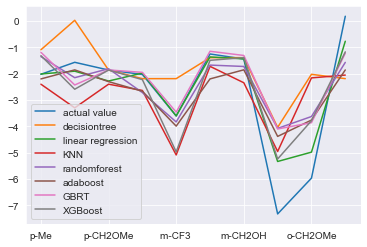

In [22]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
file_path = r"D:\Programming\algorithm\AI\mlchem\Q.txt"
txt =np.loadtxt(file_path)
txtdf = pd.DataFrame(txt,index = ['actual value', 'decisiontree', 'linear regression','KNN','randomforest', 'adaboost','GBRT','XGBoost'],
                     columns=('p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2'))
txtdf = txtdf.T
labels = ['p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2']


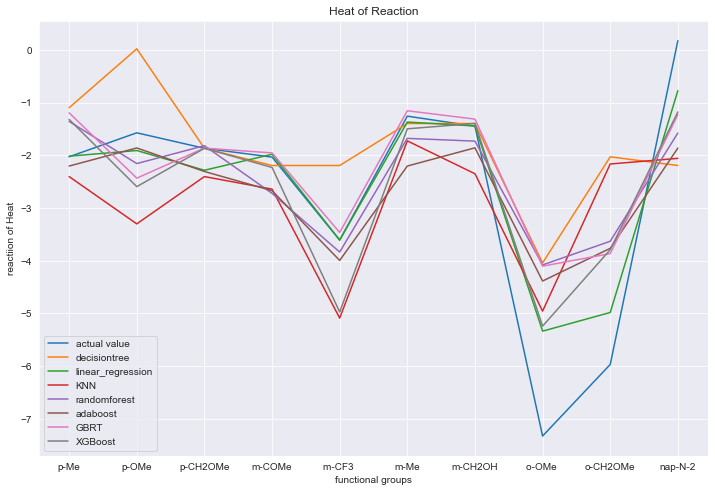

In [25]:
actual_value = txtdf['actual value'].values
decisiontree = txtdf['decisiontree'].values
linear_regression = txtdf['linear regression'].values
KNN = txtdf['KNN'].values
randomforest = txtdf['randomforest'].values
adaboost = txtdf['adaboost'].values
GBRT = txtdf['GBRT'].values
XGBoost = txtdf['XGBoost'].values
x = ['p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2']
plt.figure(figsize=(12, 8))
plt.plot(x, actual_value, label = "actual value")
plt.plot(x, decisiontree, label = "decisiontree")
plt.plot(x, linear_regression, label = "linear_regression")
plt.plot(x, KNN, label = "KNN")
plt.plot(x, randomforest, label = "randomforest")
plt.plot(x, adaboost, label = "adaboost")
plt.plot(x, GBRT, label = "GBRT")
plt.plot(x, XGBoost, label = "XGBoost")

plt.title("Heat of Reaction")
plt.xlabel("functional groups")
plt.ylabel("reactiion of Heat")
plt.legend()
plt.savefig("Q_test.jpg")
plt.show()

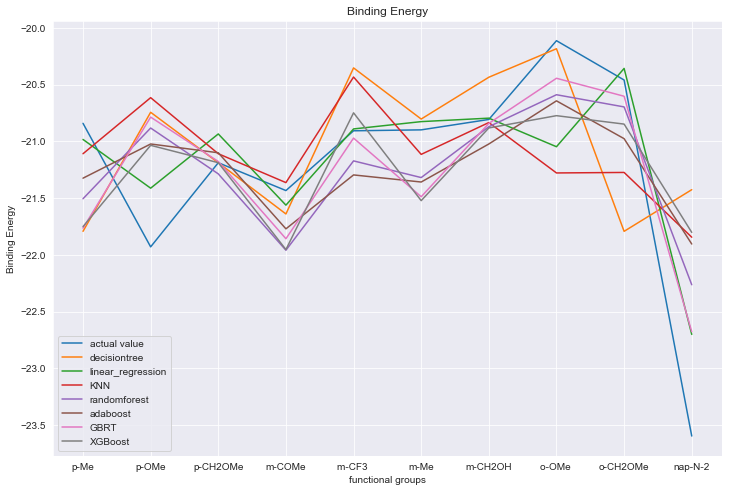

In [26]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
file_path = r"D:\Programming\algorithm\AI\mlchem\BE1.txt"
txt =np.loadtxt(file_path)
txtdf = pd.DataFrame(txt,index = ['actual value', 'decisiontree', 'linear regression','KNN','randomforest', 'adaboost','GBRT','XGBoost'],
                     columns=('p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2'))
txtdf = txtdf.T

actual_value = txtdf['actual value'].values
decisiontree = txtdf['decisiontree'].values
linear_regression = txtdf['linear regression'].values
KNN = txtdf['KNN'].values
randomforest = txtdf['randomforest'].values
adaboost = txtdf['adaboost'].values
GBRT = txtdf['GBRT'].values
XGBoost = txtdf['XGBoost'].values
x = ['p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2']
plt.figure(figsize=(12, 8))
plt.plot(x, actual_value, label = "actual value")
plt.plot(x, decisiontree, label = "decisiontree")
plt.plot(x, linear_regression, label = "linear_regression")
plt.plot(x, KNN, label = "KNN")
plt.plot(x, randomforest, label = "randomforest")
plt.plot(x, adaboost, label = "adaboost")
plt.plot(x, GBRT, label = "GBRT")
plt.plot(x, XGBoost, label = "XGBoost")

plt.title("Binding Energy")
plt.xlabel("functional groups")
plt.ylabel("Binding Energy")
plt.legend()
plt.savefig("BE_test.jpg")
plt.show()

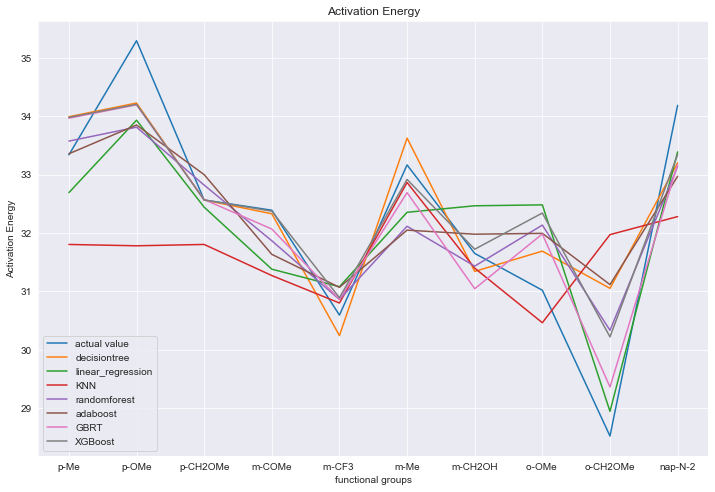

In [27]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
file_path = r"D:\Programming\algorithm\AI\mlchem\AE.txt"
txt =np.loadtxt(file_path)
txtdf = pd.DataFrame(txt,index = ['actual value', 'decisiontree', 'linear regression','KNN','randomforest', 'adaboost','GBRT','XGBoost'],
                     columns=('p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2'))
txtdf = txtdf.T

actual_value = txtdf['actual value'].values
decisiontree = txtdf['decisiontree'].values
linear_regression = txtdf['linear regression'].values
KNN = txtdf['KNN'].values
randomforest = txtdf['randomforest'].values
adaboost = txtdf['adaboost'].values
GBRT = txtdf['GBRT'].values
XGBoost = txtdf['XGBoost'].values
x = ['p-Me', 'p-OMe', 'p-CH2OMe', 'm-COMe', 'm-CF3 ', 'm-Me', 'm-CH2OH',
       'o-OMe ', 'o-CH2OMe', 'nap-N-2']
plt.figure(figsize=(12, 8))
plt.plot(x, actual_value, label = "actual value")
plt.plot(x, decisiontree, label = "decisiontree")
plt.plot(x, linear_regression, label = "linear_regression")
plt.plot(x, KNN, label = "KNN")
plt.plot(x, randomforest, label = "randomforest")
plt.plot(x, adaboost, label = "adaboost")
plt.plot(x, GBRT, label = "GBRT")
plt.plot(x, XGBoost, label = "XGBoost")

plt.title("Activation Energy")
plt.xlabel("functional groups")
plt.ylabel("Activation Energy")
plt.legend()
plt.savefig("AE_test.jpg")
plt.show()